In [74]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow.keras as k
from IPython.display import clear_output


import csv
import os
import json

In [75]:
# Initialize lists instead of numpy arrays
train_inputs = []
train_outputs = []
train_outputs_oh = []
validation_inputs = []
validation_outputs = []
validation_outputs_oh = []
test_inputs = []
test_outputs = []
test_outputs_oh = []

print("loading data...")
output_format = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'clubs', 'spades', 'hearts', 'diamonds', 'joker']
output_format_oh = [None for _ in range(53)]

with open('data/cards.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')

    flag = True  # skip headers
    for row in csv_reader:
        if flag:
            headers = row
            flag = False
        else:
            img = np.asarray(Image.open('data/'+row[1]))

            # Determine output
            class_index = int(row[0])
            name = row[2]
            if output_format_oh[class_index] is None:
                output_format_oh[class_index] = name

            output_oh = [1 if class_index == i else 0 for i in range(len(output_format_oh))]
            name_parts = name.split(' of ')
            if len(name_parts) == 1:
                output = [0] * 17 + [1]
            else:
                # print(name_parts)
                rank = [1 if (name_parts[0] == field or name_parts[1] == field) else 0 for field in output_format]
                print(f"{rank} -> {name}")
                output = rank

            # Assembling data
            if row[4] == 'train':
                train_inputs.append(img)
                train_outputs.append(output)
                train_outputs_oh.append(output_oh)
            elif row[4] == 'test':
                test_inputs.append(img)
                test_outputs.append(output)
                test_outputs_oh.append(output_oh)
            elif row[4] == 'valid':
                validation_inputs.append(img)
                validation_outputs.append(output)
                validation_outputs_oh.append(output_oh)

# Convert lists to numpy arrays and handle post-processing like normalization
train_inputs = np.array(train_inputs) / 255.0
train_outputs = np.array(train_outputs)
train_outputs_oh = np.array(train_outputs_oh)

validation_inputs = np.array(validation_inputs) / 255.0
validation_outputs = np.array(validation_outputs)
validation_outputs_oh = np.array(validation_outputs_oh)

test_inputs = np.array(test_inputs) / 255.0
test_outputs = np.array(test_outputs)
test_outputs_oh = np.array(test_outputs_oh)

print("Data importing complete")
print()
print("Output format: ")
for i, format_name in enumerate(output_format):
    if format_name is None:
        raise ValueError(f"None value found at index {i} of output format")
    else:
        print(f"\t{i} - {format_name}")


loading data...
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace of clubs
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] -> ace

In [76]:
def parse_output(output: np.array) -> str:
    """
    Parse the output from a list of numbers into a string like 'joker' or 'ace of hearts' or 'eight of spades'
    :param output: the output from the DL model as a list of 18 numbers between 0 and 1
    :return: string name of the card
    """
    test = [not (0 <= num <= 1) for num in output] # Find values out of correct range -> [False, True, False, False, ...]
    if output.shape != np.array(output_format_oh).shape and output.shape != np.array(output_format).shape:
        raise ValueError('output is not of the correct shape')
    elif any(test):
        raise ValueError(f'Output is not correctly formatted. All values in output must be between 0 and 1.\n'
                         f'given output: {output}\n'
                         f'\thas incorrect values at indices {[i if test[i] else _ for i in range(len(test))]}')
    if output.shape == np.array(output_format_oh).shape:
        index = np.argmax(output)
        return output_format_oh[index]
    elif output.shape == np.array(output_format).shape:
        if np.argmax(output) == 17:
            return 'joker'
        else:
            rank = np.argmax(output[:13])
            print(output_format[:13])
            suit = np.argmax(output[13:-1])
            print(output_format[13:-1])
            return f'{output_format[rank]} of {output_format[suit + 13]}'

def build_cnn_model(c_layers=1, d_layers=2, dense_neurons=64, filters=32, max_pooling=2, stride=3, filter_size=5, dropout=0.3)-> tf.keras.Model:
    """
    Build a convolutional sequential deep learning model.
    
    :param c_layers: Number of convolutions. Default 1.
    :param d_layers: Number of fully connected layers applied after convolutions. Default 2.
    :param dense_neurons: Number of neurons in each fully connected layers. Default 64.
    :param filters: Number of filters for first convolution. Each convolution will have twice the filters of the previous layer. Default 32.
    :param max_pooling: How large should max pooling be, setting 0 or 1 will disable max pooling. Anything larger will set the max pool at a square of that size. Default 32.
    :param stride: Stride for each convolution layer. Default 3.
    :param filter_size: The size of each filter in the convolution. Default 5.
    :param dropout: How strongly to apply dropout layers, value should be between 0 and 1, with 0 disabling dropout. Default 0.3.
    :return: built but uncompiled CNN model based on parameter specifications.
    """
    model = k.Sequential()
    
    model.add(k.Input(shape=(224, 224, 3)))
    
    for i in range(c_layers):
        model.add(k.layers.Conv2D(filters * (2 ** i), (filter_size, filter_size), padding='same', strides=(stride, stride), activation=k.layers.LeakyReLU(negative_slope=0.01)))
        model.add(k.layers.BatchNormalization())
        if max_pooling > 1:
            model.add(k.layers.MaxPooling2D((max_pooling, max_pooling)))

    
    model.add(k.layers.Flatten())
    for i in range(d_layers):
        model.add(k.layers.Dense(dense_neurons, activation=k.layers.LeakyReLU(negative_slope=0.01)))
    
    if dropout > 0:
        model.add(k.layers.Dropout(dropout))
        
    model.add(k.layers.Dense(len(output_format_oh), activation='softmax'))
    
    return model

(7624, 224, 224, 3)
(18,)
['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king']
['clubs', 'spades', 'hearts', 'diamonds']
['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king']
['clubs', 'spades', 'hearts', 'diamonds']
three of clubs
	ace - 0
	two - 0
	three - 1
	four - 0
	five - 0
	six - 0
	seven - 0
	eight - 0
	nine - 0
	ten - 0
	jack - 0
	queen - 0
	king - 0
	clubs - 1
	spades - 0
	hearts - 0
	diamonds - 0
	joker - 0
['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king']
['clubs', 'spades', 'hearts', 'diamonds']
['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king']
['clubs', 'spades', 'hearts', 'diamonds']
jack of spades
	ace - 0
	two - 0
	three - 0
	four - 0
	five - 0
	six - 0
	seven - 0
	eight - 0
	nine - 0
	ten - 0
	jack - 1
	queen - 0
	king - 0
	clubs - 0
	spades - 1
	hearts - 0
	

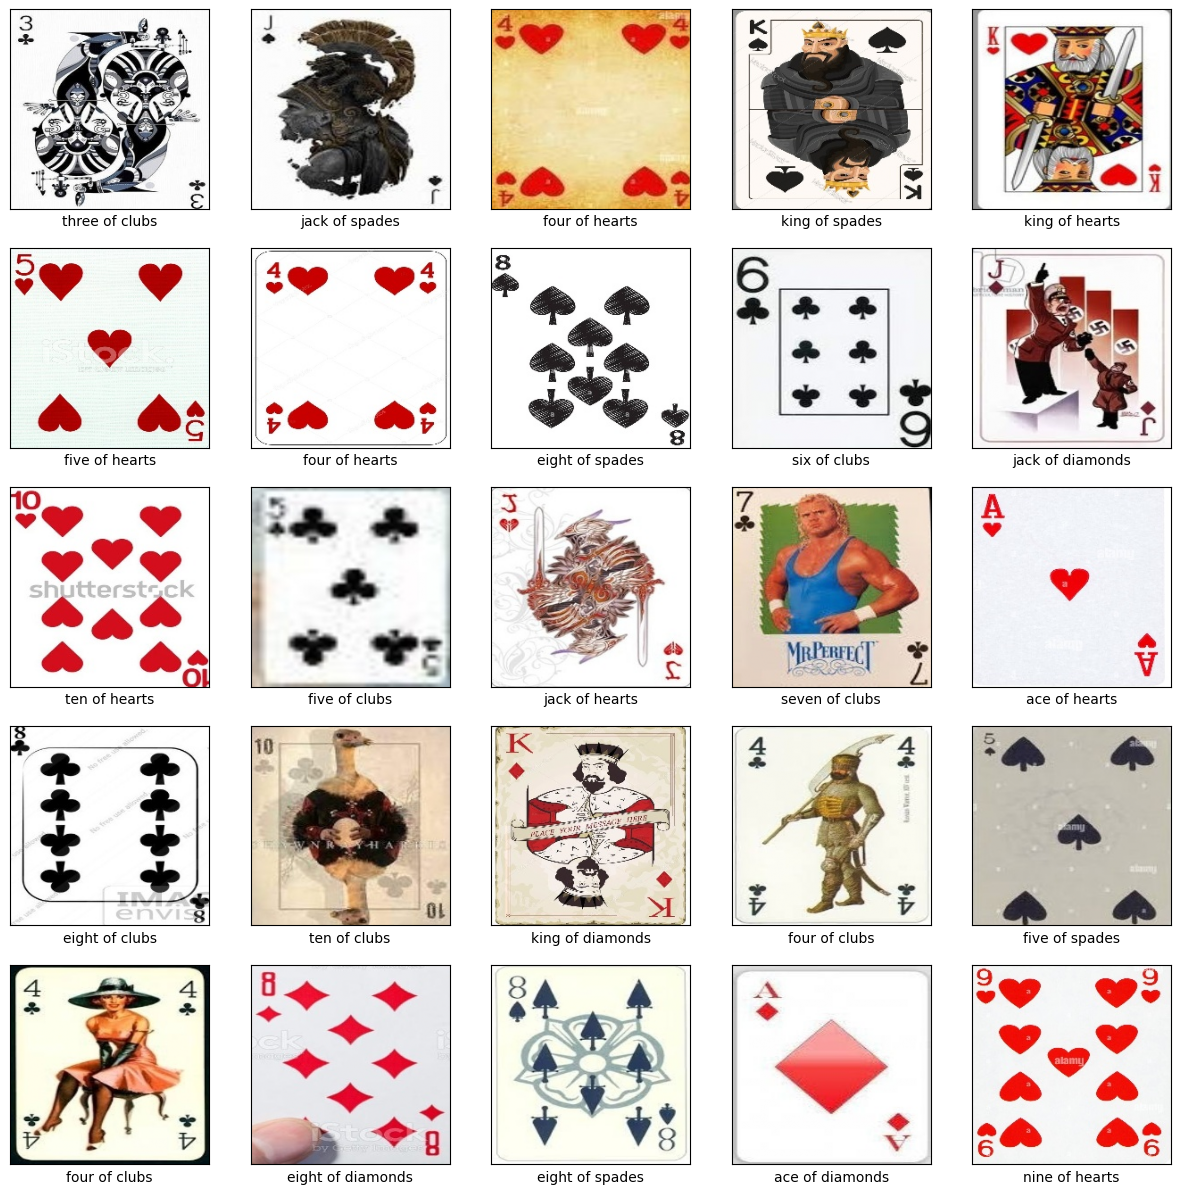

In [77]:
# check random samples
import random
from math import sqrt, ceil
print(train_inputs.shape)
num_samples = 25

print(train_outputs[0].shape)
samples = []
index = random.randint(0, len(train_inputs) - 1)
while len(samples) < 25: # grab 25 different samples
    if index not in samples:
        samples.append(index)
    index = random.randint(0, len(train_inputs) - 1)

plt.figure(figsize=[15,15]) # plot the samples
counter = 1
dim = ceil(sqrt(num_samples))

for index in samples:
    # print(train_inputs[index])
    plt.subplot(dim, dim, counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_inputs[index])
    plt.xlabel(parse_output(train_outputs[index]))
    counter += 1
    print(parse_output(train_outputs[index]))
    for i in range(len(output_format)):
        print(f"\t{output_format[i]} - {train_outputs[index][i]}")
    
plt.show()
        

In [78]:
# k.utils.plot_model(model)
learning_rates = [0.005]
decay_rates = [1]
decay_steps = [0.12, 0.13, 0.14]

params = [] # create a list of parameter combinations
models = [] # create a list of models
a = 0
for learning_rate in learning_rates:
    for decay in decay_rates:
        for step in decay_steps:
            params.append({'learning rate': learning_rate, 'decay rate': decay, 'decay steps': step})
            models.append(build_cnn_model(c_layers=2, d_layers=2, dense_neurons=128, filters=16, filter_size=5, stride=3))
            a += 1
print(f"{a} total models")
models[0].summary()

3 total models


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 75, 75, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 75, 75, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 13, 13, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,173 (723.33 KB)

 Trainable params: 185,077 (722.96 KB)

 Non-trainable params: 96 (384.00 B)

In [79]:
# Learning rate scheduler

num_epochs = 50
base_checkpoint_path = "checkpoints/"
num_correct = []

i = 0
histories = []
results = []
for model in models:
    lr = params[i]["learning rate"]
    dr = params[i]["decay rate"]
    ds = params[i]["decay steps"]
    checkpoint_path = base_checkpoint_path + f"lr{lr}dr{dr}ds{ds}/".replace('.', '-')
    clear_output()
    
    print(f"Model {i}/{a}: ({round(i/a, 2) * 100}%)")
    for key, value in params[i].items():
        print(f"\t{key} - {value}")
    
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=ds * len(train_inputs),
        decay_rate=dr
    )
    
    # Create an optimizer with the learning rate schedule
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
    
    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    # Create a callback that saves the model's weights
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = k.callbacks.ModelCheckpoint(filepath=checkpoint_path+'model.weights.h5',
                                                 save_weights_only=True,
                                                 verbose=1)
    
    # Compile model
    if False:# os.path.exists(checkpoint_path):
        # model.load_weights(checkpoint_path+'model.weights.h5')
        # with open(checkpoint_path + 'model_info.json', 'r') as openfile:
        #     # Reading from json file
        #     model_info = json.load(openfile)
        # print(f"Model {i} imported")
        pass
    else:
        model_info = {"total_epochs": num_epochs, "trained_epochs": 0, "trained_accuracy": 0.0, "val_accuracy": 0.0, "train_loss": 0.0, "val_loss": 0.0}
        print(f"Model {i} created")
    model.compile(optimizer=opt, loss=k.losses.categorical_crossentropy, metrics=['accuracy'])
    
    for j in range(model_info["trained_epochs"] + 1, model_info["total_epochs"]):
        # train the model
        history = model.fit(
            train_inputs, train_outputs_oh,
            epochs=1,
            batch_size=32,
            validation_data=(validation_inputs, validation_outputs_oh),
            verbose=1, 
            callbacks=[early_stopping, cp_callback]
        )
        
        model_info["trained_epochs"] = j
        model_info["trained_loss"] = history.history["loss"][-1]
        model_info["train_accuracy"] = history.history["accuracy"][-1]
        model_info["val_accuracy"] = history.history["val_accuracy"][-1]
        model_info["val_loss"] = history.history["val_loss"][-1]
        
        try:
            with open(checkpoint_path + 'model_info.json', "w") as outfile:
                json.dump(model_info, outfile)
        
            histories.append(history)
        except KeyboardInterrupt:
            print("Possible corrupted data")
            exit(1)
            
        y_pred = model.predict(test_inputs)
            
    correct = 0
    for index in range(len(test_outputs)):
        pred_output = np.argmax(y_pred[index])
        actual_output = np.argmax(test_outputs[index])
        if pred_output == actual_output:
            correct += 1
        
    num_correct.append(correct)
    i += 1

print(num_correct)
max_index = num_correct.index(max(num_correct))
print(max_index)
print(f"Best parameters:")
for key, value in params[max_index].items():
    print(f"\t{key} - {value}")
    
print(f"with {num_correct[max_index]} correct identifications ({100 * round((num_correct[max_index] / len(test_outputs)), 4)}%)")


Model 2/3: (67.0%)
	learning rate - 0.005
	decay rate - 1
	decay steps - 0.14
Model 2 created
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0958 - loss: 3.8031
Epoch 1: saving model to checkpoints/lr0-005dr1ds0-14/model.weights.h5
239/239 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.0964 - loss: 3.7983 - val_accuracy: 0.3132 - val_loss: 2.2601
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2929 - loss: 2.4008
Epoch 1: saving model to checkpoints/lr0-005dr1ds0-14/model.weights.h5
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.2930 - loss: 2.4004 - val_accuracy: 0.4000 - val_loss: 1.7948
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3477 - loss: 2.1677
Epoch 1: saving model to checkpoints/lr0-005dr1ds0-14/model.weights.h5
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.3478 - loss: 2.1675 - val_accuracy: 0.4642 - val_loss: 1.5955
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

In [80]:
# max_index = np.argmax(num_correct)
# print(max_index)
max_index = 0
while num_correct[max_index] != max(num_correct):
    max_index += 1
print(len(params))
print(max(num_correct))
print(num_correct[45:])


print(f"Best parameters:")
for key, value in params[max_index].items():
    print(f"\t{key} - {value}")
    
print(f"with {num_correct[max_index]} correct identifications ({round((num_correct[max_index] / len(test_outputs)), 4)}%)")

3
11
[]
Best parameters:
	learning rate - 0.005
	decay rate - 1
	decay steps - 0.14
with 11 correct identifications (0.0415%)
